In [1]:
import pandas
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk
import json
import pandas as pd
import numpy as np

### Final script to run inference on missing images

In [2]:
# check if there are any missing images

#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/inferTs'
#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/inferTs'
#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_1e2lr__nnUNetPlans__3d_fullres_maxnum_512_patch_192/inferTs'
inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs__nnUNetPlans__3d_fullres/inferTs'

inference_folder = '/gpfs3/well/papiez/users/hri611/python/nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/inferTs222_postcropping'
GT_labels = '/gpfs3/well/papiez/users/hri611/python/nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/labelsTs222_postcropping'

#GT_labels = 'nnUnet_raw/Dataset220_PETCT/labelsTs'

GT_images = os.listdir(GT_labels)
inference_images = [x for x in os.listdir(inference_folder) if '.nii.gz' in x]
union_images = set(inference_images).intersection(GT_images)

missing_inference = set(GT_images) - union_images
missing_inference_ids = [x.split(".")[0] for x in missing_inference]
len(missing_inference_ids)

# # if there are missing images:

# inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/inferTs'
# GT_labels = 'nnUnet_raw/Dataset220_PETCT/labelsTs'
# GT_images = os.listdir(GT_labels)
# inference_images = [x for x in os.listdir(inference_folder) if '.nii.gz' in x]
# union_images = set(inference_images).intersection(GT_images)
# missing_inference = set(GT_images) - union_images
# missing_inference_ids = [x.split(".")[0] for x in missing_inference]
# len(missing_inference_ids)
# import shutil
# # copy the corresponding PET and corresponding CT images
# os.mkdir('nnUnet_raw/Dataset219_PETCT/imagesTs_extra3')
# extra_folder = 'nnUnet_raw/Dataset219_PETCT/imagesTs_extra3'
# images_ts_folder =b 'nnUnet_raw/Dataset220_PETCT/imagesTs'
# for image in os.listdir(images_ts_folder):
#     for missing in missing_inference:
#         if missing[:-8] in image:
#             shutil.copy(os.path.join(images_ts_folder,image),extra_folder)

0

In [10]:
dice_list=[]
for image in [x for x in os.listdir(inference_folder) if ".nii.gz" in x]:
    dice,b,c = compute_metrics(os.path.join(GT_labels,image), os.path.join(inference_folder,image))
    dice_list.append(dice)



/tmp/slurm-29535622/ipykernel_169952/2279298215.py:93: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2*overlap/sum


In [17]:
np.nanmean(dice_list)

0.885952687397718

## Compute challenge metrics

In [7]:
import pandas
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk
import json
import pandas as pd
import numpy as np
import numpy as np
import pathlib as plb
import cc3d
import csv
import sys

#path_to_results219="nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4/postprocessed/summary.json"
#path_to_results219="nnUNet_results/Dataset219_PETCT/nnUNetTrainer_probabilisticOversampling_033__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2/postprocessed/summary.json"
#path_to_results219="nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_1e2lr__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4/postprocessed/summary.json"
path_to_results219="nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4/postprocessed/summary.json"

def make_results_df(path_to_summary_json): 
    with open(path_to_summary_json, "r") as read_file:
            dict_results = json.load(read_file)

    metrics_per_case = dict_results['metric_per_case']
    results = []
    for case in metrics_per_case:
        metrics = case['metrics']['1']
        row = {
            'DICE': metrics['Dice'],
            'FN': metrics['FN'],
            'FP': metrics['FP'],
            'IoU': metrics['IoU'],
            'TN': metrics['TN'],
            'TP': metrics['TP'],
            'n_pred': metrics['n_pred'],
            'n_ref': metrics['n_ref'],
            'prediction_file': case['prediction_file'],
            'reference_file': case['reference_file']
            }
        results.append(row)

    df = pd.DataFrame(results)
    
    return df

def nii2numpy(nii_path):
    # input: path of NIfTI segmentation file, output: corresponding numpy array and voxel_vol in ml
    mask_nii = nib.load(str(nii_path))
    mask = mask_nii.get_fdata()
    pixdim = mask_nii.header['pixdim']   
    voxel_vol = pixdim[1]*pixdim[2]*pixdim[3]/1000
    return mask, voxel_vol


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def false_pos_pix(gt_array,pred_array):
    # compute number of voxels of false positive connected components in prediction mask
    pred_conn_comp = con_comp(pred_array)
    
    false_pos = 0
    for idx in range(1,pred_conn_comp.max()+1):
        comp_mask = np.isin(pred_conn_comp, idx)
        if (comp_mask*gt_array).sum() == 0:
            false_pos = false_pos+comp_mask.sum()
    return false_pos



def false_neg_pix(gt_array,pred_array):
    # compute number of voxels of false negative connected components (of the ground truth mask) in the prediction mask
    gt_conn_comp = con_comp(gt_array)
    
    false_neg = 0
    for idx in range(1,gt_conn_comp.max()+1):
        comp_mask = np.isin(gt_conn_comp, idx)
        if (comp_mask*pred_array).sum() == 0:
            false_neg = false_neg+comp_mask.sum()
            
    return false_neg


def dice_score(mask1,mask2):
    # compute foreground Dice coefficient
    overlap = (mask1*mask2).sum()
    sum = mask1.sum()+mask2.sum()
    dice_score = 2*overlap/sum
    return dice_score



def compute_metrics(nii_gt_path, nii_pred_path):
    # main function
    gt_array, voxel_vol = nii2numpy(nii_gt_path)
    pred_array, voxel_vol = nii2numpy(nii_pred_path)

    false_neg_vol = false_neg_pix(gt_array, pred_array) #*voxel_vol
    false_pos_vol = false_pos_pix(gt_array, pred_array) #*voxel_vol
    dice_sc = dice_score(gt_array,pred_array)

    return dice_sc, false_pos_vol, false_neg_vol

df = make_results_df(path_to_results219)
print('df worked')

df['challenge_DICE'], df['challenge_FP'],df['challenge_FN'] = zip(*df.apply(lambda row: compute_metrics(row['reference_file'], row['prediction_file']), axis=1))

df.to_csv('h-219-CV-all-results.csv')

df worked


KeyboardInterrupt: 

In [5]:
import numpy as np
import nibabel as nib
import pathlib as plb
import cc3d
import csv
import sys


def nii2numpy(nii_path):
    # input: path of NIfTI segmentation file, output: corresponding numpy array and voxel_vol in ml
    mask_nii = nib.load(str(nii_path))
    mask = mask_nii.get_fdata()
    pixdim = mask_nii.header['pixdim']   
    voxel_vol = pixdim[1]*pixdim[2]*pixdim[3]/1000
    return mask, voxel_vol


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def false_pos_pix(gt_array,pred_array):
    # compute number of voxels of false positive connected components in prediction mask
    pred_conn_comp = con_comp(pred_array)
    
    false_pos = 0
    for idx in range(1,pred_conn_comp.max()+1):
        comp_mask = np.isin(pred_conn_comp, idx)
        if (comp_mask*gt_array).sum() == 0:
            false_pos = false_pos+comp_mask.sum()
    return false_pos


def false_neg_pix(gt_array,pred_array):
    # compute number of voxels of false negative connected components (of the ground truth mask) in the prediction mask
    gt_conn_comp = con_comp(gt_array)
    
    false_neg = 0
    for idx in range(1,gt_conn_comp.max()+1):
        comp_mask = np.isin(gt_conn_comp, idx)
        if (comp_mask*pred_array).sum() == 0:
            false_neg = false_neg+comp_mask.sum()
            
    return false_neg


def dice_score(mask1,mask2):
    # compute foreground Dice coefficient
    overlap = (mask1*mask2).sum()
    sum = mask1.sum()+mask2.sum()
    dice_score = 2*overlap/sum
    return dice_score



def compute_metrics(nii_gt_path, nii_pred_path):
    # main function
    gt_array, voxel_vol = nii2numpy(nii_gt_path)
    pred_array, voxel_vol = nii2numpy(nii_pred_path)

    false_neg_vol = false_neg_pix(gt_array, pred_array) *voxel_vol
    false_pos_vol = false_pos_pix(gt_array, pred_array) *voxel_vol
    dice_sc = dice_score(gt_array,pred_array)

    return dice_sc, false_pos_vol, false_neg_vol

def compute_inf_results(infernece_folder, inference_images, GT_labels_folder, GT_images, output_df):
    # compute challenge metrics on inference images and save results as csv 

    path_names = []
    dice = []
    fp= []
    fn = []
    for i in range(len(inference_images)):
        print(i)
        nii_gt_path, nii_pred_path = os.path.join(GT_labels_folder,inference_images[i]),os.path.join(inference_folder,inference_images[i])
        nii_gt_path = plb.Path(nii_gt_path)
        nii_pred_path = plb.Path(nii_pred_path)
        dice_sc, false_pos_vol, false_neg_vol = compute_metrics(nii_gt_path, nii_pred_path)

        csv_header = ['gt_name', 'dice_sc', 'false_pos_vol', 'false_neg_vol']
        path_names.append(nii_gt_path.name)
        dice.append(dice_sc)
        fp.append(false_pos_vol)
        fn.append(false_neg_vol)
    
    metrics_df = pd.DataFrame()
    metrics_df['image'],metrics_df['DICE'],metrics_df['challenge_FP'],metrics_df['challenge_FN'] = path_names,dice,fp,fn
    
    metrics_df.to_csv(output_df)

In [6]:
#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/inferTs'
#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/inferTs'
#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_probabilisticOversampling_033__nnUNetPlans__3d_fullres/inferTs'
#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_1e2lr__nnUNetPlans__3d_fullres/inferTs'
#inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres_maxnum_512_patch_192/inferTs' #d
inference_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs__nnUNetPlans__3d_fullres/inferTs'

GT_labels_folder = 'nnUnet_raw/Dataset220_PETCT/labelsTs'

GT_images = os.listdir(GT_labels_folder)
inference_images = [x for x in os.listdir(inference_folder) if '.nii.gz' in x]
compute_inf_results(inference_folder,inference_images,GT_labels_folder,GT_images,'h_219_inf_results.csv')
    

0
1
2
3
4


/tmp/slurm-28449733/ipykernel_98181/932727212.py:54: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2*overlap/sum


5
6
7
8


KeyboardInterrupt: 

### Analyse inference results

In [2]:
from datetime import datetime

clinical_data_df = pd.read_csv('Clinical Metadata FDG PET_CT Lesions (1).csv')
#clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: x.replace("/", ""))

# add zeros to date so it is compatible w/ other data
clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: (datetime.strptime(x, "%m/%d/%Y")).strftime("%m%d%Y"))

clinical_data_df['filename'] = clinical_data_df['Subject ID'].astype(str) + "_" + clinical_data_df['Study Date'].astype(str)


In [3]:
clinical_data_df

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,diagnosis,age,sex
0,1.3.6.1.4.1.14519.5.2.1.4219.6651.201203836389...,FDG-PET-CT-Lesions,NO,NaN,PETCT_0011f3deaf,1.3.6.1.4.1.14519.5.2.1.4219.6651.389860614478...,PET-CT Ganzkoerper primaer mit KM,03232003,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.75 MB,./FDG-PET-CT-Lesions/PETCT_0011f3deaf/03-23-20...,2022-03-17T12:53:16.75,MELANOMA,063Y,F
1,1.3.6.1.4.1.14519.5.2.1.4219.6651.685145825998...,FDG-PET-CT-Lesions,NO,NaN,PETCT_0011f3deaf,1.3.6.1.4.1.14519.5.2.1.4219.6651.389860614478...,PET-CT Ganzkoerper primaer mit KM,03232003,PET corr.,SIEMENS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,326,105.82 MB,./FDG-PET-CT-Lesions/PETCT_0011f3deaf/03-23-20...,2022-03-17T12:53:44.865,MELANOMA,063Y,F
2,1.3.6.1.4.1.14519.5.2.1.4219.6651.151532511484...,FDG-PET-CT-Lesions,NO,NaN,PETCT_01140d52d8,1.3.6.1.4.1.14519.5.2.1.4219.6651.316964892168...,PET-CT Ganzkoerper primaer mit KM,08132005,PET corr.,SIEMENS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,305,99.01 MB,./FDG-PET-CT-Lesions/PETCT_01140d52d8/08-13-20...,2022-03-17T12:53:45.761,MELANOMA,061Y,M
3,1.3.6.1.4.1.14519.5.2.1.4219.6651.313152023416...,FDG-PET-CT-Lesions,NO,NaN,PETCT_01140d52d8,1.3.6.1.4.1.14519.5.2.1.4219.6651.316964892168...,PET-CT Ganzkoerper primaer mit KM,08132005,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.31 MB,./FDG-PET-CT-Lesions/PETCT_01140d52d8/08-13-20...,2022-03-17T12:53:47.839,MELANOMA,061Y,M
4,1.3.6.1.4.1.14519.5.2.1.4219.6651.331726561677...,FDG-PET-CT-Lesions,NO,NaN,PETCT_0011f3deaf,1.3.6.1.4.1.14519.5.2.1.4219.6651.389860614478...,PET-CT Ganzkoerper primaer mit KM,03232003,GK p.v.3,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,391,206.52 MB,./FDG-PET-CT-Lesions/PETCT_0011f3deaf/03-23-20...,2022-03-17T12:53:53.415,MELANOMA,063Y,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,1.3.6.1.4.1.14519.5.2.1.4219.6651.268371672619...,FDG-PET-CT-Lesions,NO,NaN,PETCT_ff1451316e,1.3.6.1.4.1.14519.5.2.1.4219.6651.172967091722...,PET-CT Ganzkoerper primaer mit KM,03312003,GK p.v.3,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,391,206.53 MB,./FDG-PET-CT-Lesions/PETCT_ff1451316e/03-31-20...,2022-03-17T21:50:46.509,NEGATIVE,073Y,M
3038,1.3.6.1.4.1.14519.5.2.1.4219.6651.236102552014...,FDG-PET-CT-Lesions,NO,NaN,PETCT_fe705ea1cc,1.3.6.1.4.1.14519.5.2.1.4219.6651.319090403244...,Unspecified CT ABDOMEN,12292002,GK p.v.1 WF,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,1214,641.06 MB,./FDG-PET-CT-Lesions/PETCT_fe705ea1cc/12-29-20...,2022-03-17T21:51:00.132,LYMPHOMA,066Y,F
3039,1.3.6.1.4.1.14519.5.2.1.4219.6651.330497593503...,FDG-PET-CT-Lesions,NO,NaN,PETCT_ff39795341,1.3.6.1.4.1.14519.5.2.1.4219.6651.253687934564...,PET-CT Ganzkoerper primaer mit KM,09222005,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,11.13 MB,./FDG-PET-CT-Lesions/PETCT_ff39795341/09-22-20...,2022-03-17T21:51:04.996,NEGATIVE,073Y,F
3040,1.3.6.1.4.1.14519.5.2.1.4219.6651.117635362952...,FDG-PET-CT-Lesions,NO,NaN,PETCT_ff39795341,1.3.6.1.4.1.14519.5.2.1.4219.6651.253687934564...,PET-CT Ganzkoerper primaer mit KM,09222005,GK p.v.3 s,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,645,340.68 MB,./FDG-PET-CT-Lesions/PETCT_ff39795341/09-22-20...,2022-03-17T21:51:26.506,NEGATIVE,073Y,F


In [11]:
clinical_data_df['filename'] = clinical_data_df['Subject ID'].astype(str) + "_" + clinical_data_df['Study Date'].astype(str)


In [12]:
clinical_data_df['filename'][0]

'PETCT_0011f3deaf_03232003'

In [13]:
clinical_data_df

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,...,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,diagnosis,age,sex,filename
0,1.3.6.1.4.1.14519.5.2.1.4219.6651.201203836389...,FDG-PET-CT-Lesions,NO,NaN,PETCT_0011f3deaf,1.3.6.1.4.1.14519.5.2.1.4219.6651.389860614478...,PET-CT Ganzkoerper primaer mit KM,03232003,Segmentation,QIICR,...,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.75 MB,./FDG-PET-CT-Lesions/PETCT_0011f3deaf/03-23-20...,2022-03-17T12:53:16.75,MELANOMA,063Y,F,PETCT_0011f3deaf_03232003
1,1.3.6.1.4.1.14519.5.2.1.4219.6651.685145825998...,FDG-PET-CT-Lesions,NO,NaN,PETCT_0011f3deaf,1.3.6.1.4.1.14519.5.2.1.4219.6651.389860614478...,PET-CT Ganzkoerper primaer mit KM,03232003,PET corr.,SIEMENS,...,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,326,105.82 MB,./FDG-PET-CT-Lesions/PETCT_0011f3deaf/03-23-20...,2022-03-17T12:53:44.865,MELANOMA,063Y,F,PETCT_0011f3deaf_03232003
2,1.3.6.1.4.1.14519.5.2.1.4219.6651.151532511484...,FDG-PET-CT-Lesions,NO,NaN,PETCT_01140d52d8,1.3.6.1.4.1.14519.5.2.1.4219.6651.316964892168...,PET-CT Ganzkoerper primaer mit KM,08132005,PET corr.,SIEMENS,...,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,305,99.01 MB,./FDG-PET-CT-Lesions/PETCT_01140d52d8/08-13-20...,2022-03-17T12:53:45.761,MELANOMA,061Y,M,PETCT_01140d52d8_08132005
3,1.3.6.1.4.1.14519.5.2.1.4219.6651.313152023416...,FDG-PET-CT-Lesions,NO,NaN,PETCT_01140d52d8,1.3.6.1.4.1.14519.5.2.1.4219.6651.316964892168...,PET-CT Ganzkoerper primaer mit KM,08132005,Segmentation,QIICR,...,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.31 MB,./FDG-PET-CT-Lesions/PETCT_01140d52d8/08-13-20...,2022-03-17T12:53:47.839,MELANOMA,061Y,M,PETCT_01140d52d8_08132005
4,1.3.6.1.4.1.14519.5.2.1.4219.6651.331726561677...,FDG-PET-CT-Lesions,NO,NaN,PETCT_0011f3deaf,1.3.6.1.4.1.14519.5.2.1.4219.6651.389860614478...,PET-CT Ganzkoerper primaer mit KM,03232003,GK p.v.3,SIEMENS,...,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,391,206.52 MB,./FDG-PET-CT-Lesions/PETCT_0011f3deaf/03-23-20...,2022-03-17T12:53:53.415,MELANOMA,063Y,F,PETCT_0011f3deaf_03232003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,1.3.6.1.4.1.14519.5.2.1.4219.6651.268371672619...,FDG-PET-CT-Lesions,NO,NaN,PETCT_ff1451316e,1.3.6.1.4.1.14519.5.2.1.4219.6651.172967091722...,PET-CT Ganzkoerper primaer mit KM,03312003,GK p.v.3,SIEMENS,...,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,391,206.53 MB,./FDG-PET-CT-Lesions/PETCT_ff1451316e/03-31-20...,2022-03-17T21:50:46.509,NEGATIVE,073Y,M,PETCT_ff1451316e_03312003
3038,1.3.6.1.4.1.14519.5.2.1.4219.6651.236102552014...,FDG-PET-CT-Lesions,NO,NaN,PETCT_fe705ea1cc,1.3.6.1.4.1.14519.5.2.1.4219.6651.319090403244...,Unspecified CT ABDOMEN,12292002,GK p.v.1 WF,SIEMENS,...,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,1214,641.06 MB,./FDG-PET-CT-Lesions/PETCT_fe705ea1cc/12-29-20...,2022-03-17T21:51:00.132,LYMPHOMA,066Y,F,PETCT_fe705ea1cc_12292002
3039,1.3.6.1.4.1.14519.5.2.1.4219.6651.330497593503...,FDG-PET-CT-Lesions,NO,NaN,PETCT_ff39795341,1.3.6.1.4.1.14519.5.2.1.4219.6651.253687934564...,PET-CT Ganzkoerper primaer mit KM,09222005,Segmentation,QIICR,...,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,11.13 MB,./FDG-PET-CT-Lesions/PETCT_ff39795341/09-22-20...,2022-03-17T21:51:04.996,NEGATIVE,073Y,F,PETCT_ff39795341_09222005
3040,1.3.6.1.4.1.14519.5.2.1.4219.6651.117635362952...,FDG-PET-CT-Lesions,NO,NaN,PETCT_ff39795341,1.3.6.1.4.1.14519.5.2.1.4219.6651.253687934564...,PET-CT Ganzkoerper primaer mit KM,09222005,GK p.v.3 s,SIEMENS,...,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,645,340.68 MB,./FDG-PET-CT-Lesions/PETCT_ff39795341/09-22-20...,2022-03-17T21:51:26.506,NEGATIVE,073Y,F,PETCT_ff39795341_09222005


In [5]:
from datetime import datetime

clinical_data_df = pd.read_csv('Clinical Metadata FDG PET_CT Lesions (1).csv')
#clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: x.replace("/", ""))

# add zeros to date so it is compatible w/ other data
clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: (datetime.strptime(x, "%m/%d/%Y")).strftime("%m%d%Y"))

def load_process_inf_metrics(input_df):
    f_metrics_df = pd.read_csv(input_df)
    f_metrics_df['subject_id'] = f_metrics_df['image'].apply(lambda x: x.split('_')[0]+"_"+x.split('_')[1])
    f_metrics_df['subject_date'] = f_metrics_df['image'].apply(lambda x: x.split('_')[2].split(".")[0])
    
    f_metrics_df = f_metrics_df.drop(columns=['Unnamed: 0'])
    
    # Merge the two DataFrames based on 'subject_id' and 'subject_date'
    merged_df = f_metrics_df.merge(clinical_data_df, left_on=['subject_id', 'subject_date'], right_on=['Subject ID', 'Study Date'], how='left')

    # Drop the duplicate columns 'Subject ID' and 'Study Date' (optional, if you want to keep only one set of them)
    merged_df.drop(columns=['Subject ID', 'Study Date'], inplace=True)

    # Rename the 'Diagnosis' column to 'diagnosis' (optional, if you want to match the column name)
    merged_df.rename(columns={'Diagnosis': 'diagnosis'}, inplace=True)
    
    return merged_df

In [6]:
default_metrics_df = load_process_inf_metrics('default_219_inf_results.csv')
f_metrics_df = load_process_inf_metrics('f_219_inf_results.csv')
#a_metrics_df = load_process_inf_metrics('a_219_inf_results.csv')
e_metrics_df = load_process_inf_metrics('e_219_inf_results.csv')
d_metrics_df = load_process_inf_metrics('d_219_inf_results.csv')
c_metrics_df = load_process_inf_metrics('c_219_inf_results.csv')
h_metrics_df =load_process_inf_metrics('h_219_inf_results.csv')

In [7]:
h_metrics_df

,image,DICE,challenge_FP,challenge_FN,subject_id,subject_date,Series UID,Collection,3rd Party Analysis,Data Description URI,...,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,diagnosis,age,sex
0,PETCT_b1219c408b_10042002.nii.gz,0.765990,0.000000,1.642215,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.627386788876...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:40:54.334,LUNG_CANCER,076Y,F
1,PETCT_b1219c408b_10042002.nii.gz,0.765990,0.000000,1.642215,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.186532901553...,FDG-PET-CT-Lesions,NO,NaN,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,284,92.19 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:41:05.158,LUNG_CANCER,076Y,F
2,PETCT_b1219c408b_10042002.nii.gz,0.765990,0.000000,1.642215,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.274042968402...,FDG-PET-CT-Lesions,NO,NaN,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,340,179.58 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:41:25.068,LUNG_CANCER,076Y,F
3,PETCT_ca89066e44_08112005.nii.gz,0.788448,3.284430,0.024882,PETCT_ca89066e44,08112005,1.3.6.1.4.1.14519.5.2.1.4219.6651.133158759828...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.21 MB,./FDG-PET-CT-Lesions/PETCT_ca89066e44/08-11-20...,2022-03-17T19:43:10.546,LYMPHOMA,040Y,F
4,PETCT_ca89066e44_08112005.nii.gz,0.788448,3.284430,0.024882,PETCT_ca89066e44,08112005,1.3.6.1.4.1.14519.5.2.1.4219.6651.529235374488...,FDG-PET-CT-Lesions,NO,NaN,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,300,97.39 MB,./FDG-PET-CT-Lesions/PETCT_ca89066e44/08-11-20...,2022-03-17T19:43:42.369,LYMPHOMA,040Y,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,PETCT_38733c001e_07282006.nii.gz,NaN,0.000000,0.000000,PETCT_38733c001e,07282006,1.3.6.1.4.1.14519.5.2.1.4219.6651.151638158380...,FDG-PET-CT-Lesions,NO,NaN,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,353,114.60 MB,./FDG-PET-CT-Lesions/PETCT_38733c001e/07-28-20...,2022-03-17T14:26:19.9,NEGATIVE,050Y,M
281,PETCT_38733c001e_07282006.nii.gz,NaN,0.000000,0.000000,PETCT_38733c001e,07282006,1.3.6.1.4.1.14519.5.2.1.4219.6651.201889395124...,FDG-PET-CT-Lesions,NO,NaN,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,423,223.44 MB,./FDG-PET-CT-Lesions/PETCT_38733c001e/07-28-20...,2022-03-17T14:26:35.882,NEGATIVE,050Y,M
282,PETCT_ddca6cfba6_02272004.nii.gz,0.841385,0.186615,0.049764,PETCT_ddca6cfba6,02272004,1.3.6.1.4.1.14519.5.2.1.4219.6651.341014394771...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_ddca6cfba6/02-27-20...,2022-03-17T20:41:41.282,LYMPHOMA,025Y,M
283,PETCT_ddca6cfba6_02272004.nii.gz,0.841385,0.186615,0.049764,PETCT_ddca6cfba6,02272004,1.3.6.1.4.1.14519.5.2.1.4219.6651.243767863274...,FDG-PET-CT-Lesions,NO,NaN,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,340,179.58 MB,./FDG-PET-CT-Lesions/PETCT_ddca6cfba6/02-27-20...,2022-03-17T20:42:16.965,LYMPHOMA,025Y,M


In [8]:
seg_df = h_metrics_df[h_metrics_df['Modality']=='SEG']
#seg_df = e_metrics_df[e_metrics_df['Modality']=='SEG']
print(seg_df[seg_df['diagnosis']!='NEGATIVE']['DICE'].mean())
print(seg_df[seg_df['diagnosis']!='NEGATIVE']['challenge_FN'].mean())
print(seg_df['challenge_FP'].mean())

0.6795294425310557
7.375783689651489
8.042923617071855


### Overall results

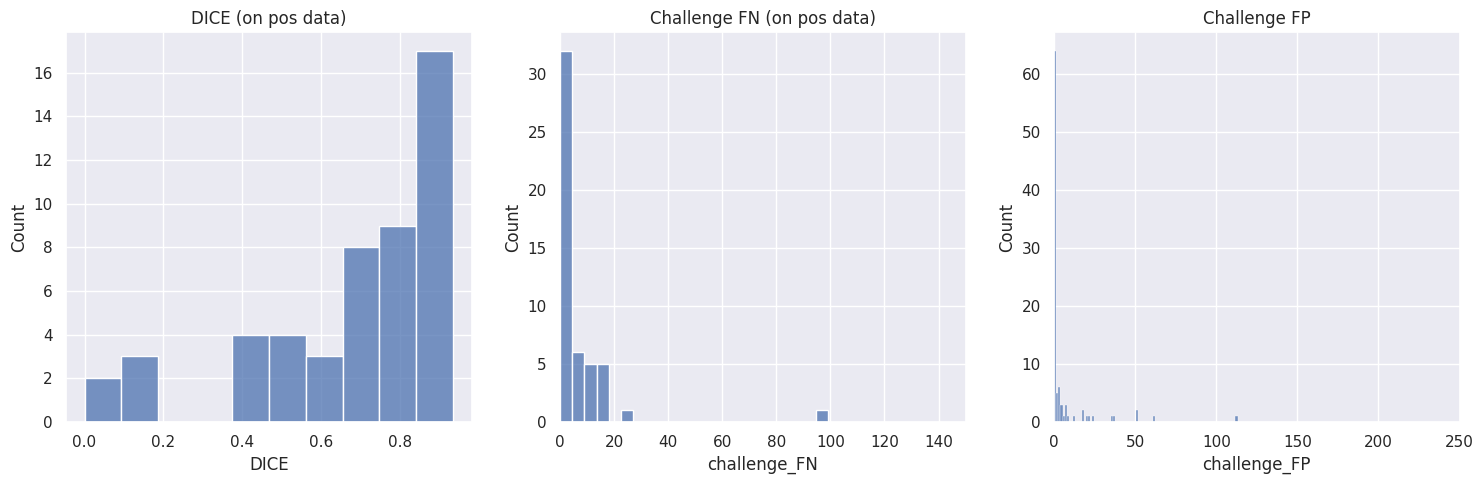

In [22]:
seg_df = a_metrics_df[a_metrics_df['Modality']=='SEG']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(data=seg_df[seg_df['diagnosis']!='NEGATIVE'], x='DICE', ax=axes[0],bins=10)
axes[0].set_title('DICE (on pos data)')

sns.histplot(data=seg_df[seg_df['diagnosis']!='NEGATIVE'], x='challenge_FN', ax=axes[1])
axes[1].set_title('Challenge FN (on pos data)')
axes[1].set_xlim(0, 150)

sns.histplot(data=seg_df, x='challenge_FP', ax=axes[2])
axes[2].set_title('Challenge FP')
axes[2].set_xlim(0, 250)


plt.tight_layout()
plt.show()

Text(0.5, 0, 'FP scores on negative test data')

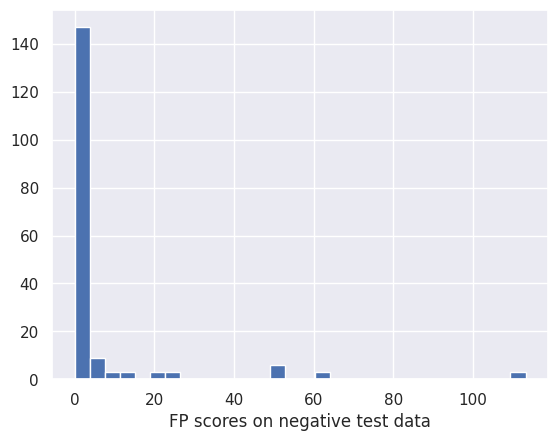

In [24]:
plt.hist(a_metrics_df[a_metrics_df['challenge_FN']==0]['challenge_FP'],bins=30)
plt.xlabel('FP scores on negative test data')


In [25]:
a_metrics_df['FP-FN']=a_metrics_df['challenge_FP']-a_metrics_df['challenge_FN']
a_metrics_df['FP-FN'].mean()

2.477858501996492

## Check for any differences within clusters

In [8]:
a_metrics_df.columns

Index(['image', 'DICE', 'challenge_FP', 'challenge_FN', 'subject_id',
       'subject_date', 'Series UID', 'Collection', '3rd Party Analysis',
       'Data Description URI', 'Study UID', 'Study Description',
       'Series Description', 'Manufacturer', 'Modality', 'SOP Class Name',
       'SOP Class UID', 'Number of Images', 'File Size', 'File Location',
       'Download Timestamp', 'diagnosis', 'age', 'sex'],
      dtype='object')

### Diagnosis:

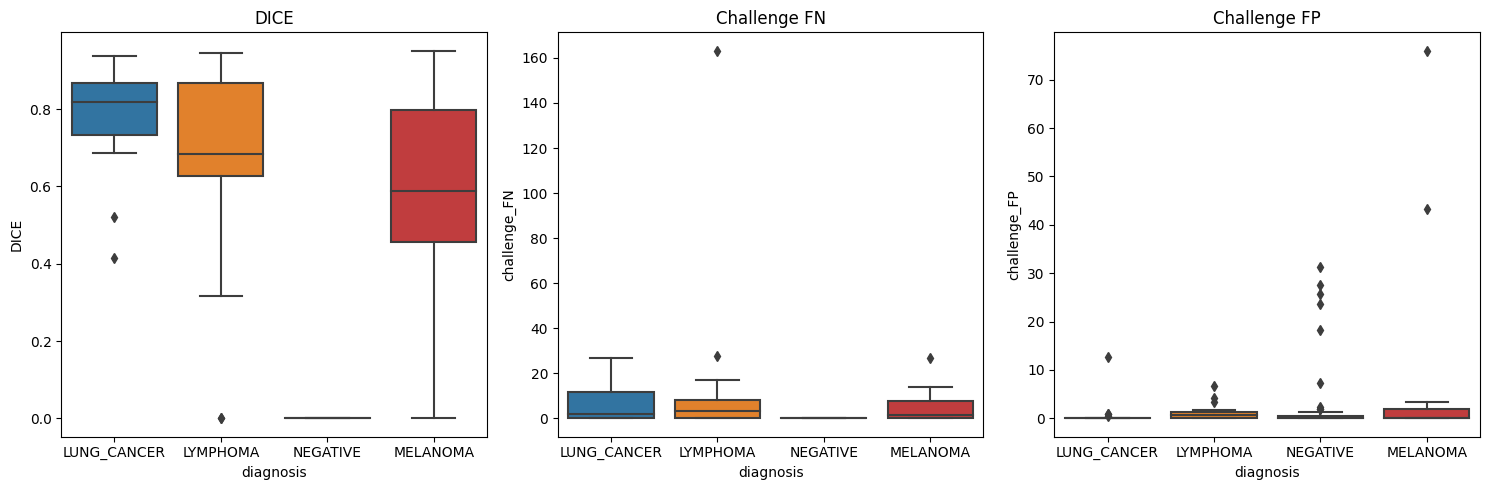

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

seg_df = d_metrics_df[d_metrics_df['Modality']=='SEG']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.boxplot(data=seg_df, x='diagnosis', y='DICE', ax=axes[0])
axes[0].set_title('DICE')

sns.boxplot(data=seg_df, x='diagnosis', y='challenge_FN', ax=axes[1])
axes[1].set_title('Challenge FN')

sns.boxplot(data=seg_df, x='diagnosis', y='challenge_FP', ax=axes[2])
axes[2].set_title('Challenge FP')

plt.tight_layout()
plt.show()

### Sex

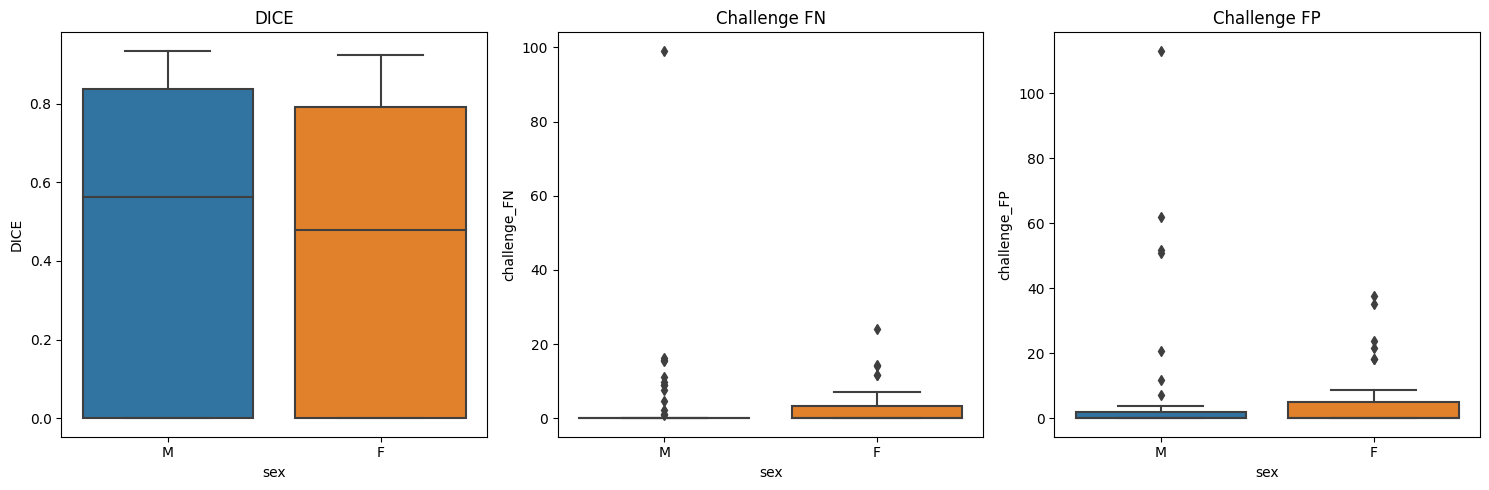

In [10]:
seg_df = a_metrics_df[a_metrics_df['Modality']=='SEG']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.boxplot(data=seg_df, x='sex', y='DICE', ax=axes[0])
axes[0].set_title('DICE')
sns.boxplot(data=seg_df, x='sex', y='challenge_FN', ax=axes[1])
axes[1].set_title('Challenge FN')
sns.boxplot(data=seg_df, x='sex', y='challenge_FP', ax=axes[2])
axes[2].set_title('Challenge FP')

plt.tight_layout()
plt.show()

### Age

/tmp/slurm-23209841/ipykernel_2455/2481780884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pet_df['age'] = pet_df['age'].str.rstrip('Y').astype(int)


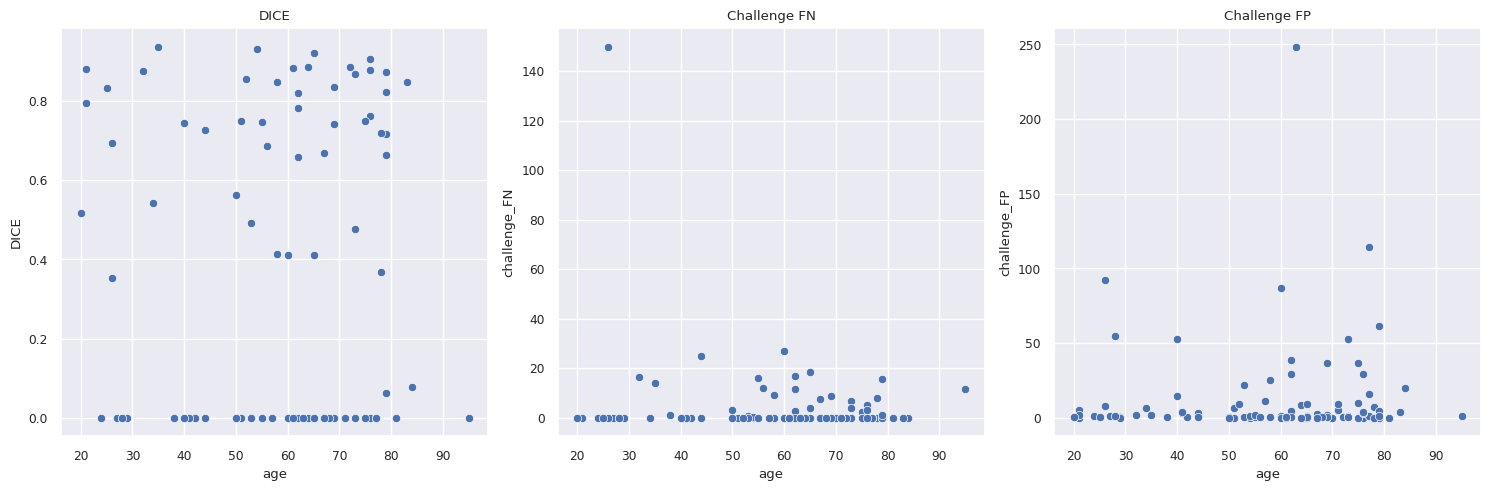

In [149]:
pet_df = f_metrics_df[f_metrics_df['Modality']=='CT']

pet_df['age'] = pet_df['age'].str.rstrip('Y').astype(int)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=pet_df, x='age', y='DICE', ax=axes[0])
axes[0].set_title('DICE')

sns.scatterplot(data=pet_df, x='age', y='challenge_FN', ax=axes[1])
axes[1].set_title('Challenge FN')

sns.scatterplot(data=pet_df, x='age', y='challenge_FP', ax=axes[2])
axes[2].set_title('Challenge FP')

plt.tight_layout()
plt.show()

In [155]:
unique_values = pet_df['Study Description'].unique()

print(unique_values)

['PET-CT Ganzkoerper  primaer mit KM' 'PET-CT Ganzkoerper nativ'
 'Unspecified CT' 'PET-CT Ganzkoerper nativ u. mit KM'
 'Unspecified CT ABDOMEN']


### "Study description" 

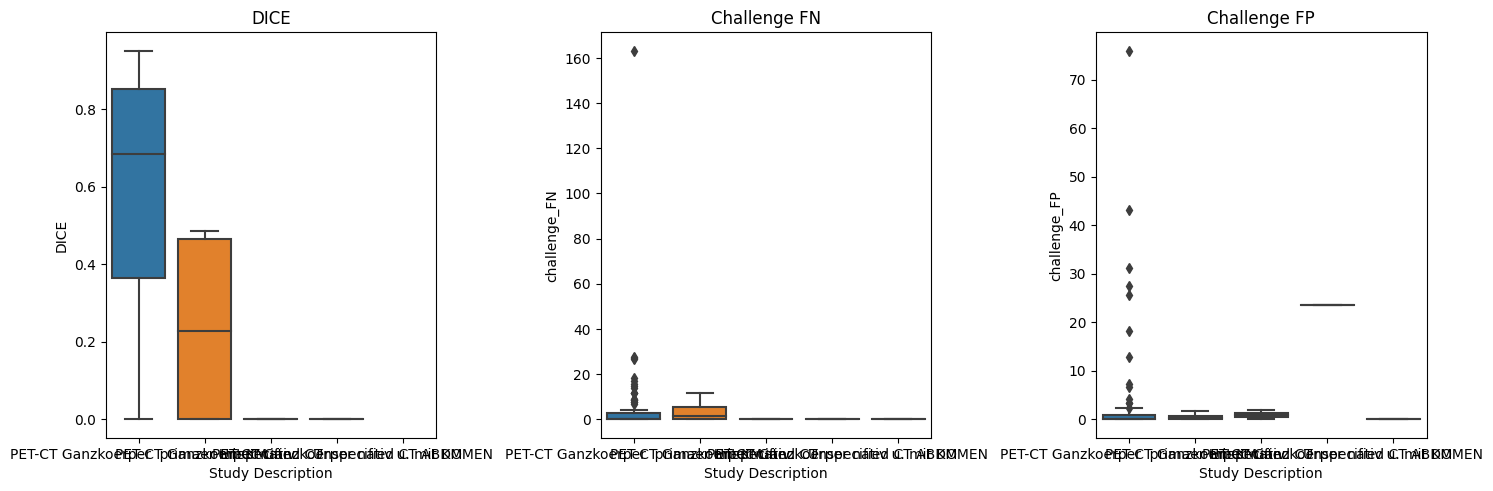

In [19]:
pet_df = d_metrics_df[d_metrics_df['Modality']=='CT']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


sns.boxplot(data=seg_df, x='Study Description', y='DICE', ax=axes[0])
axes[0].set_title('DICE')

sns.boxplot(data=seg_df, x='Study Description', y='challenge_FN', ax=axes[1])
axes[1].set_title('Challenge FN')

sns.boxplot(data=seg_df, x='Study Description', y='challenge_FP', ax=axes[2])
axes[2].set_title('Challenge FP')

sns.set(font_scale=0.8)

plt.tight_layout()
plt.show()


In [168]:
len(pet_df[pet_df['Study Description']=='Unspecified CT ABDOMEN'])

1

### CT type

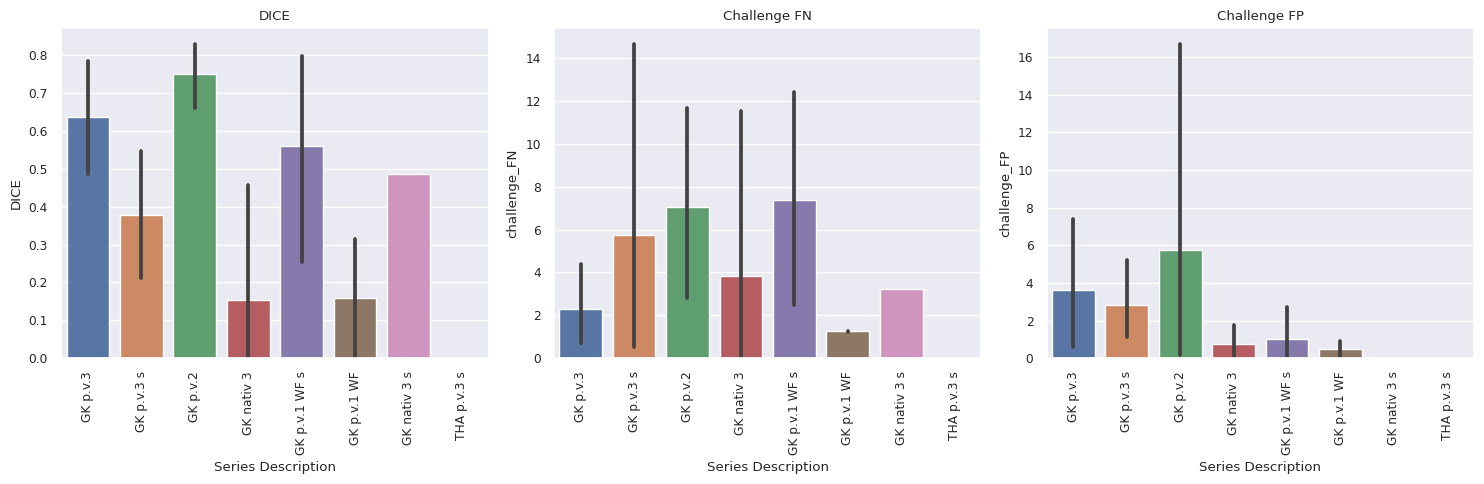

In [20]:
pet_df = d_metrics_df[d_metrics_df['Modality']=='CT']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.barplot(data=pet_df, x='Series Description', y='DICE', ax=axes[0])
axes[0].set_title('DICE')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.barplot(data=pet_df, x='Series Description', y='challenge_FN', ax=axes[1])
axes[1].set_title('Challenge FN')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

sns.barplot(data=pet_df, x='Series Description', y='challenge_FP', ax=axes[2])
axes[2].set_title('Challenge FP')

sns.set(font_scale=1)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


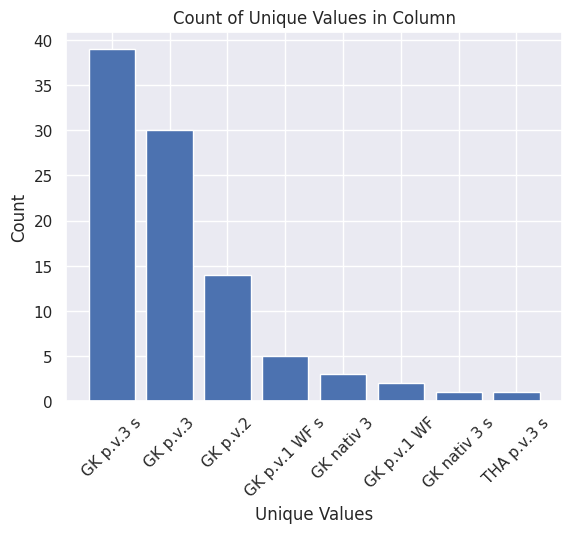

In [16]:
value_counts = pet_df['Series Description'].value_counts()

# Create a bar plot using matplotlib
plt.bar(value_counts.index, value_counts.values)

# Add labels to the plot
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Column')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Number of images

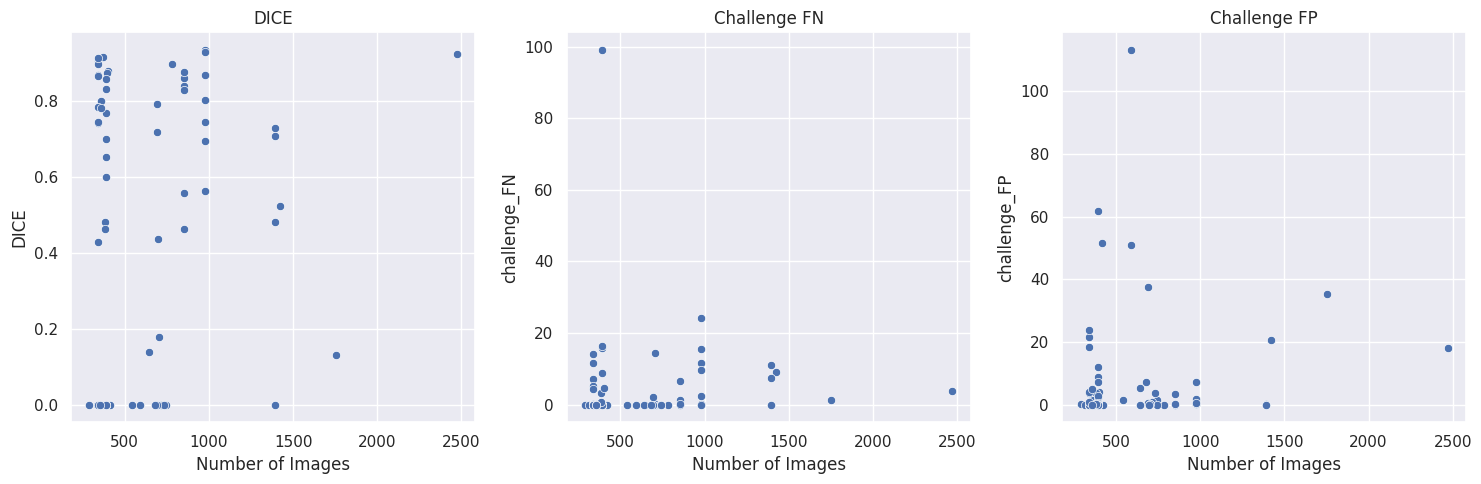

In [14]:
pet_df = a_metrics_df[a_metrics_df['Modality']=='CT']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=pet_df, x='Number of Images', y='DICE', ax=axes[0])
axes[0].set_title('DICE')

sns.scatterplot(data=pet_df, x='Number of Images', y='challenge_FN', ax=axes[1])
axes[1].set_title('Challenge FN')

sns.scatterplot(data=pet_df, x='Number of Images', y='challenge_FP', ax=axes[2])
axes[2].set_title('Challenge FP')

plt.tight_layout()
plt.show()

## Post-process each set of inference images

In [2]:
dict_of_paths = {'a':['a_219_inf_results.csv','nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres']}
dict_of_paths['default']=['default_219_inf_results.csv','nnUNetTrainer__nnUNetPlans__3d_fullres']
dict_of_paths['f'] = ['f_219_inf_results.csv','nnUNetTrainer_probabilisticOversampling_033__nnUNetPlans__3d_fullres']
dict_of_paths['e'] = ['e_219_inf_results.csv','nnUNetTrainer_1500epochs_1e2lr__nnUNetPlans__3d_fullres']
dict_of_paths['d'] = ['d_219_inf_results.csv','nnUNetTrainer__nnUNetPlans__3d_fullres_maxnum_512_patch_192']
dict_of_paths['c'] = ['c_219_inf_results.csv','nnUNetTrainer_1500epochs_1e2lr__nnUNetPlans__3d_fullres_maxnum_512_patch_192']

In [3]:
dict_of_paths

{'a': ['a_219_inf_results.csv',
  'nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres'],
 'default': ['default_219_inf_results.csv',
  'nnUNetTrainer__nnUNetPlans__3d_fullres'],
 'f': ['f_219_inf_results.csv',
  'nnUNetTrainer_probabilisticOversampling_033__nnUNetPlans__3d_fullres'],
 'e': ['e_219_inf_results.csv',
  'nnUNetTrainer_1500epochs_1e2lr__nnUNetPlans__3d_fullres'],
 'd': ['d_219_inf_results.csv',
  'nnUNetTrainer__nnUNetPlans__3d_fullres_maxnum_512_patch_192'],
 'c': ['c_219_inf_results.csv',
  'nnUNetTrainer_1500epochs_1e2lr__nnUNetPlans__3d_fullres_maxnum_512_patch_192']}

In [4]:
def process_array(arr,min_size):
    min_size = int(min_size)
    
    unique_elements, counts = np.unique(arr, return_counts=True)

    # Create a mapping to change values less than 125 to 0
    change_to_zero = unique_elements[counts < min_size]

    # Create a new array with the same values as the input array
    processed_arr = arr.copy()

    # Change values less than 125 to 0
    for val in change_to_zero:
        processed_arr[processed_arr == val] = 0
        
    processed_arr[processed_arr != 0] = 1

    return processed_arr

def post_process_nifti(nifti_pred_path,output_path,min_size):
    # get numpy array
    pred_array, voxel_vol = nii2numpy(nifti_pred_path)
    pred_conn_comp = con_comp(pred_array)
    
    # returns numpy array with removal of small connected components
    processed_arr = process_array(pred_conn_comp,min_size)
    
    # return and save nifti image
    nifti_img = nib.Nifti1Image(processed_arr, affine=np.eye(4)) 
    nib.save(nifti_img, output_path)

from datetime import datetime

clinical_data_df = pd.read_csv('Clinical Metadata FDG PET_CT Lesions (1).csv')
#clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: x.replace("/", ""))

# add zeros to date so it is compatible w/ other data
clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: (datetime.strptime(x, "%m/%d/%Y")).strftime("%m%d%Y"))

def load_process_inf_metrics_from_df(input_df):
    f_metrics_df = input_df
    f_metrics_df['subject_id'] = f_metrics_df['image'].apply(lambda x: x.split('_')[0]+"_"+x.split('_')[1])
    f_metrics_df['subject_date'] = f_metrics_df['image'].apply(lambda x: x.split('_')[2].split(".")[0])
    
    #f_metrics_df = f_metrics_df.drop(columns=['Unnamed: 0'])
    
    # Merge the two DataFrames based on 'subject_id' and 'subject_date'
    merged_df = f_metrics_df.merge(clinical_data_df, left_on=['subject_id', 'subject_date'], right_on=['Subject ID', 'Study Date'], how='left')

    # Drop the duplicate columns 'Subject ID' and 'Study Date' (optional, if you want to keep only one set of them)
    merged_df.drop(columns=['Subject ID', 'Study Date'], inplace=True)

    # Rename the 'Diagnosis' column to 'diagnosis' (optional, if you want to match the column name)
    merged_df.rename(columns={'Diagnosis': 'diagnosis'}, inplace=True)
    
    return merged_df


In [33]:
GT_labels_folder = 'nnUnet_raw/Dataset220_PETCT/labelsTs'
base_path = 'nnUNet_results/Dataset219_PETCT/'

# iterate through each model
for key in dict_of_paths.keys():
    print(key)
    relative_path = dict_of_paths[key][1]

    # create folder for pp images
    processed_inference_folder = os.path.join(base_path,relative_path,'pp10_inferTs')
    if not os.path.exists(processed_inference_folder):
        os.mkdir(processed_inference_folder)

    # get non-processed inference images
    inference_folder = os.path.join(base_path,relative_path,'inferTs')
    inference_images = [x for x in os.listdir(inference_folder) if '.nii.gz' in x]

    # apply post processing and save images to folder
    for image in inference_images:
        post_process_nifti(os.path.join(inference_folder,image),os.path.join(processed_inference_folder,image),10)

    print('post-processing finished')
    
    # calculate new metrics and save results
    path_names = []
    dice = []
    fp= []
    fn = []
    for i in range(len(inference_images)):
        nii_gt_path, nii_pred_path = os.path.join(GT_labels_folder,inference_images[i]),os.path.join(processed_inference_folder,inference_images[i])
        nii_gt_path = plb.Path(nii_gt_path)
        nii_pred_path = plb.Path(nii_pred_path)
        dice_sc, false_pos_vol, false_neg_vol = compute_metrics(nii_gt_path, nii_pred_path)
    
        csv_header = ['gt_name', 'dice_sc', 'false_pos_vol', 'false_neg_vol']
        path_names.append(nii_gt_path.name)
        dice.append(dice_sc)
        fp.append(false_pos_vol)
        fn.append(false_neg_vol)

    print('metrics calculated')
    
    pp_metrics_df = pd.DataFrame()
    pp_metrics_df['image'],pp_metrics_df['DICE'],pp_metrics_df['challenge_FP'],pp_metrics_df['challenge_FN'] = path_names,dice,fp,fn

    # add column in df for diagnosis
    pp_metrics_df = load_process_inf_metrics_from_df(pp_metrics_df)

    print('made df and merged with clinical data df')
    
    df_name = str(key) + '-219-10pp-CV-results.csv'
    pp_metrics_df.to_csv(df_name)

    print('metrics saved as df')


a
post-processing finished


/tmp/slurm-24671075/ipykernel_212775/932727212.py:54: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2*overlap/sum


metrics calculated


KeyError: "['Unnamed: 0'] not found in axis"

In [5]:
for key in dict_of_paths.keys():
    print(key)
    df_name = str(key) + '-219-10pp-CV-results.csv'
    df = pd.read_csv(df_name)
    seg_df = df[df['Modality']=='SEG']
    #seg_df = e_metrics_df[e_metrics_df['Modality']=='SEG']
    print(seg_df[seg_df['diagnosis']!='NEGATIVE']['DICE'].mean())
    print(seg_df[seg_df['diagnosis']!='NEGATIVE']['challenge_FN'].mean())
    print(seg_df['challenge_FP'].mean())
        




a
0.6857476163522557
0.5405800000000001
0.4617368421052633
default
0.665876573453222
0.65404
0.9516736842105263
f
0.6626012787546657
0.69938
0.991863157894737
e
0.6112198864189451
1.2412600000000003
1.0760736842105263
d
0.6819398487361303
0.81348
0.2590210526315789
c
0.673308600967645
1.1373
0.30329473684210523


In [56]:
processed_inference_folder='nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/processedinferTs'
#os.mkdir(processed_inference_folder)

for image in inference_images:
    post_process_nifti(os.path.join(inference_folder,image),os.path.join(processed_inference_folder,image),125)

PETCT_b1219c408b_10042002.nii.gz
PETCT_ca89066e44_08112005.nii.gz
PETCT_a3ce52b2a8_11152003.nii.gz
PETCT_99e5728030_04182002.nii.gz
PETCT_68ef307665_05162003.nii.gz
PETCT_4a72eeb991_12232005.nii.gz
PETCT_89fb723947_09032000.nii.gz
PETCT_562294be56_04282003.nii.gz
PETCT_824c6a0014_12182005.nii.gz
PETCT_661ddc60e0_03082002.nii.gz
PETCT_4760c0139a_01262006.nii.gz
PETCT_2922971d0f_07192003.nii.gz
PETCT_d7ca3d4aaa_07052003.nii.gz
PETCT_c7dc6f848c_02022006.nii.gz
PETCT_2f587d00b1_09272004.nii.gz
PETCT_277fc3c67c_11152003.nii.gz
PETCT_c58b637e17_06112005.nii.gz
PETCT_8de70b5cd7_07222002.nii.gz
PETCT_572fca6b44_05232005.nii.gz
PETCT_a3ce52b2a8_10192002.nii.gz
PETCT_08cdb15e0b_11212003.nii.gz
PETCT_cb83710e3d_03102006.nii.gz
PETCT_76ebd5c736_12292005.nii.gz
PETCT_cc5c58c82d_07262001.nii.gz
PETCT_62a78a061f_08292005.nii.gz
PETCT_61348439bf_07242005.nii.gz
PETCT_2745fb1adb_12212002.nii.gz
PETCT_0dbf2c2731_10272005.nii.gz
PETCT_5a58935b68_12062002.nii.gz
PETCT_642d6c78d6_09102005.nii.gz
PETCT_29b3

### Calculate metrics after post processing

In [57]:
path_names = []
dice = []
fp= []
fn = []
for i in range(len(intersection_images)):
    print(i)
    nii_gt_path, nii_pred_path = os.path.join(GT_labels_folder,intersection_images[i]),os.path.join(processed_inference_folder,intersection_images[i])
    nii_gt_path = plb.Path(nii_gt_path)
    nii_pred_path = plb.Path(nii_pred_path)
    dice_sc, false_pos_vol, false_neg_vol = compute_metrics(nii_gt_path, nii_pred_path)

    csv_header = ['gt_name', 'dice_sc', 'false_pos_vol', 'false_neg_vol']
    path_names.append(nii_gt_path.name)
    dice.append(dice_sc)
    fp.append(false_pos_vol)
    fn.append(false_neg_vol)


0


/tmp/slurm-22926390/ipykernel_8972/3966277457.py:54: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2*overlap/sum


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


In [59]:
pp_metrics_df = pd.DataFrame()
pp_metrics_df['image'],pp_metrics_df['DICE'],pp_metrics_df['challenge_FP'],pp_metrics_df['challenge_FN'] = path_names,dice,fp,fn


In [2]:
pp_metrics_df = pd.read_csv('h-219-10pp-CV-results.csv')

In [3]:
pp_metrics_df

,Unnamed: 0,image,DICE,challenge_FP,challenge_FN,subject_id,subject_date,Series UID,Collection,3rd Party Analysis,...,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,diagnosis,age,sex
0,0,PETCT_b1219c408b_10042002.nii.gz,0.765990,0.000,0.132,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.627386788876...,FDG-PET-CT-Lesions,NO,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:40:54.334,LUNG_CANCER,076Y,F
1,1,PETCT_b1219c408b_10042002.nii.gz,0.765990,0.000,0.132,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.186532901553...,FDG-PET-CT-Lesions,NO,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,284,92.19 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:41:05.158,LUNG_CANCER,076Y,F
2,2,PETCT_b1219c408b_10042002.nii.gz,0.765990,0.000,0.132,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.274042968402...,FDG-PET-CT-Lesions,NO,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,340,179.58 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:41:25.068,LUNG_CANCER,076Y,F
3,3,PETCT_ca89066e44_08112005.nii.gz,0.788338,0.264,0.002,PETCT_ca89066e44,8112005,1.3.6.1.4.1.14519.5.2.1.4219.6651.133158759828...,FDG-PET-CT-Lesions,NO,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.21 MB,./FDG-PET-CT-Lesions/PETCT_ca89066e44/08-11-20...,2022-03-17T19:43:10.546,LYMPHOMA,040Y,F
4,4,PETCT_ca89066e44_08112005.nii.gz,0.788338,0.264,0.002,PETCT_ca89066e44,8112005,1.3.6.1.4.1.14519.5.2.1.4219.6651.529235374488...,FDG-PET-CT-Lesions,NO,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,300,97.39 MB,./FDG-PET-CT-Lesions/PETCT_ca89066e44/08-11-20...,2022-03-17T19:43:42.369,LYMPHOMA,040Y,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,280,PETCT_38733c001e_07282006.nii.gz,NaN,0.000,0.000,PETCT_38733c001e,7282006,1.3.6.1.4.1.14519.5.2.1.4219.6651.151638158380...,FDG-PET-CT-Lesions,NO,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,353,114.60 MB,./FDG-PET-CT-Lesions/PETCT_38733c001e/07-28-20...,2022-03-17T14:26:19.9,NEGATIVE,050Y,M
281,281,PETCT_38733c001e_07282006.nii.gz,NaN,0.000,0.000,PETCT_38733c001e,7282006,1.3.6.1.4.1.14519.5.2.1.4219.6651.201889395124...,FDG-PET-CT-Lesions,NO,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,423,223.44 MB,./FDG-PET-CT-Lesions/PETCT_38733c001e/07-28-20...,2022-03-17T14:26:35.882,NEGATIVE,050Y,M
282,282,PETCT_ddca6cfba6_02272004.nii.gz,0.841385,0.015,0.004,PETCT_ddca6cfba6,2272004,1.3.6.1.4.1.14519.5.2.1.4219.6651.341014394771...,FDG-PET-CT-Lesions,NO,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_ddca6cfba6/02-27-20...,2022-03-17T20:41:41.282,LYMPHOMA,025Y,M
283,283,PETCT_ddca6cfba6_02272004.nii.gz,0.841385,0.015,0.004,PETCT_ddca6cfba6,2272004,1.3.6.1.4.1.14519.5.2.1.4219.6651.243767863274...,FDG-PET-CT-Lesions,NO,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,340,179.58 MB,./FDG-PET-CT-Lesions/PETCT_ddca6cfba6/02-27-20...,2022-03-17T20:42:16.965,LYMPHOMA,025Y,M


In [9]:
seg_df = pp_metrics_df[pp_metrics_df['Modality']=='SEG']
#seg_df = e_metrics_df[e_metrics_df['Modality']=='SEG']
print(seg_df[seg_df['diagnosis']!='NEGATIVE']['DICE'].mean())
print(seg_df[seg_df['diagnosis']!='NEGATIVE']['challenge_FN'].mean())
print(seg_df['challenge_FP'].mean())

0.6796660197913111
0.62904
0.6421157894736843


In [61]:
pp_metrics_df['DICE'].mean()

0.45988456852670484

Text(0.5, 0, 'DICE scores on test data w/ removal of small connected components ')

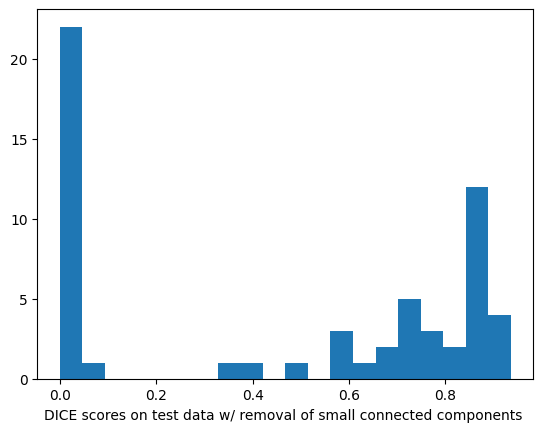

In [64]:
import matplotlib.pyplot as plt
plt.hist(pp_metrics_df['DICE'],bins=20)
plt.xlabel('DICE scores on test data w/ removal of small connected components ')

### DICE score on positive images

In [123]:
metrics_df[metrics_df['challenge_FN']!=0]['DICE'].mean()

0.6370263945523067

In [124]:
pp_metrics_df[pp_metrics_df['challenge_FN']!=0]['DICE'].mean()

0.5692522315804858

In [125]:
pp_metrics_df10[pp_metrics_df10['challenge_FN']!=0]['DICE'].mean()

0.6514994917029766

### FP score

In [119]:
metrics_df['challenge_FP'].mean()

11.484379635799632

In [117]:
pp_metrics_df['challenge_FP'].mean()

0.8433058823529411

In [118]:
pp_metrics_df10['challenge_FP'].mean()

0.9200117647058824

### FN score

In [126]:
metrics_df['challenge_FN'].mean()

2.200597061381621

In [121]:
pp_metrics_df['challenge_FN'].mean()

0.37063529411764706

In [122]:
pp_metrics_df10['challenge_FN'].mean()

0.18763529411764707

In [45]:
unique_elements, counts = np.unique(test_array == pred_conn_comp2, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")


True: 45440000 times


### Retry with smaller threshold

In [66]:
processed_inference_folder10='nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/processedinferTs_10'
os.mkdir(processed_inference_folder10)

for image in inference_images:
    post_process_nifti(os.path.join(inference_folder,image),os.path.join(processed_inference_folder10,image),10)
    

In [67]:
path_names = []
dice = []
fp= []
fn = []
for i in range(len(intersection_images)):
    print(i)
    nii_gt_path, nii_pred_path = os.path.join(GT_labels_folder,intersection_images[i]),os.path.join(processed_inference_folder10,intersection_images[i])
    nii_gt_path = plb.Path(nii_gt_path)
    nii_pred_path = plb.Path(nii_pred_path)
    dice_sc, false_pos_vol, false_neg_vol = compute_metrics(nii_gt_path, nii_pred_path)

    csv_header = ['gt_name', 'dice_sc', 'false_pos_vol', 'false_neg_vol']
    path_names.append(nii_gt_path.name)
    dice.append(dice_sc)
    fp.append(false_pos_vol)
    fn.append(false_neg_vol)

0
1
2
3
4
5
6


/tmp/slurm-22926390/ipykernel_8972/3966277457.py:54: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2*overlap/sum


7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


In [68]:
pp_metrics_df10 = pd.DataFrame()
pp_metrics_df10['image'],pp_metrics_df10['DICE'],pp_metrics_df10['challenge_FP'],pp_metrics_df10['challenge_FN'] = path_names,dice,fp,fn


In [69]:
pp_metrics_df10['DICE'].mean()

0.4050256145291059

In [70]:
pp_metrics_df10[pp_metrics_df10['challenge_FN']!=0]['DICE'].mean()

0.6514994917029766

Text(0.5, 0, 'DICE scores on test data w/ removal of connected components < 10')

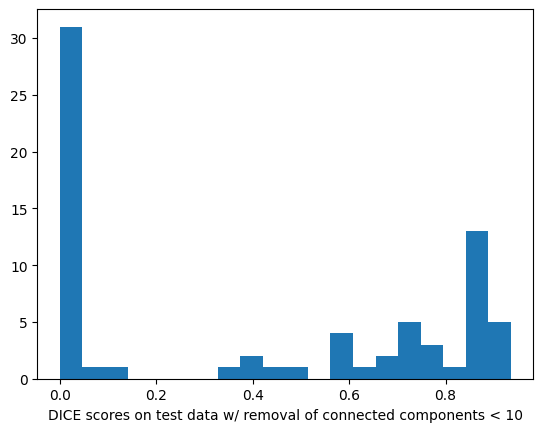

In [71]:
plt.hist(pp_metrics_df10['DICE'],bins=20)
plt.xlabel('DICE scores on test data w/ removal of connected components < 10')

In [1]:
### What is wrong with post processing and inf results?

In [26]:
import pandas as pd
import nibabel as nib
import numpy as np
import cc3d
def nii2numpy(nii_path):
    # input: path of NIfTI segmentation file, output: corresponding numpy array and voxel_vol in ml
    mask_nii = nib.load(str(nii_path))
    mask = mask_nii.get_fdata()
    pixdim = mask_nii.header['pixdim']   
    voxel_vol = pixdim[1]*pixdim[2]*pixdim[3]/1000
    return mask, voxel_vol


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def false_pos_pix(gt_array,pred_array):
    # compute number of voxels of false positive connected components in prediction mask
    pred_conn_comp = con_comp(pred_array)
    
    false_pos = 0
    for idx in range(1,pred_conn_comp.max()+1):
        comp_mask = np.isin(pred_conn_comp, idx)
        if (comp_mask*gt_array).sum() == 0:
            false_pos = false_pos+comp_mask.sum()
    return false_pos


def false_neg_pix(gt_array,pred_array):
    # compute number of voxels of false negative connected components (of the ground truth mask) in the prediction mask
    gt_conn_comp = con_comp(gt_array)
    
    false_neg = 0
    for idx in range(1,gt_conn_comp.max()+1):
        comp_mask = np.isin(gt_conn_comp, idx)
        if (comp_mask*pred_array).sum() == 0:
            false_neg = false_neg+comp_mask.sum()
            
    return false_neg


def dice_score(mask1,mask2):
    # compute foreground Dice coefficient
    overlap = (mask1*mask2).sum()
    sum = mask1.sum()+mask2.sum()
    dice_score = 2*overlap/sum
    return dice_score



def compute_metrics(nii_gt_path, nii_pred_path):
    # main function
    gt_array, voxel_vol = nii2numpy(nii_gt_path)
    pred_array, voxel_vol = nii2numpy(nii_pred_path)

    false_neg_vol = false_neg_pix(gt_array, pred_array) #*voxel_vol
    false_pos_vol = false_pos_pix(gt_array, pred_array) #*voxel_vol
    dice_sc = dice_score(gt_array,pred_array)

    return dice_sc, false_pos_vol, false_neg_vol

In [5]:
a_inf_df = pd.read_csv('a_219_inf_results.csv')
a_inf_df

,Unnamed: 0,image,DICE,challenge_FP,challenge_FN
0,0,PETCT_661ddc60e0_03082002.nii.gz,0.839286,0.000000,0.000000
1,1,PETCT_f082a3d319_11082004.nii.gz,0.000000,0.136851,0.000000
2,2,PETCT_2922971d0f_07192003.nii.gz,0.000000,8.683833,0.000000
3,3,PETCT_ae8c77a995_05182007.nii.gz,0.479889,0.000000,3.222224
4,4,PETCT_277fc3c67c_11152003.nii.gz,0.000000,21.585171,0.000000
...,...,...,...,...,...
90,90,PETCT_76ebd5c736_12292005.nii.gz,0.461538,0.111969,0.796225
91,91,PETCT_a9d7a14ba1_08142000.nii.gz,0.557038,0.049764,0.049764
92,92,PETCT_89fb723947_09032000.nii.gz,0.869232,0.634492,0.000000
93,93,PETCT_ded50b1e68_02092006.nii.gz,NaN,0.000000,0.000000


In [6]:
a_inf_pp_df = pd.read_csv('a-219-10pp-CV-results.csv')
a_inf_pp_df

,Unnamed: 0,image,DICE,challenge_FP,challenge_FN,subject_id,subject_date,Series UID,Collection,3rd Party Analysis,...,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,diagnosis,age,sex
0,0,PETCT_b1219c408b_10042002.nii.gz,0.743878,0.0,0.409,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.627386788876...,FDG-PET-CT-Lesions,NO,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:40:54.334,LUNG_CANCER,076Y,F
1,1,PETCT_b1219c408b_10042002.nii.gz,0.743878,0.0,0.409,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.186532901553...,FDG-PET-CT-Lesions,NO,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,284,92.19 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:41:05.158,LUNG_CANCER,076Y,F
2,2,PETCT_b1219c408b_10042002.nii.gz,0.743878,0.0,0.409,PETCT_b1219c408b,10042002,1.3.6.1.4.1.14519.5.2.1.4219.6651.274042968402...,FDG-PET-CT-Lesions,NO,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,340,179.58 MB,./FDG-PET-CT-Lesions/PETCT_b1219c408b/10-04-20...,2022-03-17T18:41:25.068,LUNG_CANCER,076Y,F
3,3,PETCT_ca89066e44_08112005.nii.gz,0.782298,0.0,0.002,PETCT_ca89066e44,8112005,1.3.6.1.4.1.14519.5.2.1.4219.6651.133158759828...,FDG-PET-CT-Lesions,NO,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.21 MB,./FDG-PET-CT-Lesions/PETCT_ca89066e44/08-11-20...,2022-03-17T19:43:10.546,LYMPHOMA,040Y,F
4,4,PETCT_ca89066e44_08112005.nii.gz,0.782298,0.0,0.002,PETCT_ca89066e44,8112005,1.3.6.1.4.1.14519.5.2.1.4219.6651.529235374488...,FDG-PET-CT-Lesions,NO,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,300,97.39 MB,./FDG-PET-CT-Lesions/PETCT_ca89066e44/08-11-20...,2022-03-17T19:43:42.369,LYMPHOMA,040Y,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,280,PETCT_38733c001e_07282006.nii.gz,NaN,0.0,0.000,PETCT_38733c001e,7282006,1.3.6.1.4.1.14519.5.2.1.4219.6651.151638158380...,FDG-PET-CT-Lesions,NO,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,353,114.60 MB,./FDG-PET-CT-Lesions/PETCT_38733c001e/07-28-20...,2022-03-17T14:26:19.9,NEGATIVE,050Y,M
281,281,PETCT_38733c001e_07282006.nii.gz,NaN,0.0,0.000,PETCT_38733c001e,7282006,1.3.6.1.4.1.14519.5.2.1.4219.6651.201889395124...,FDG-PET-CT-Lesions,NO,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,423,223.44 MB,./FDG-PET-CT-Lesions/PETCT_38733c001e/07-28-20...,2022-03-17T14:26:35.882,NEGATIVE,050Y,M
282,282,PETCT_ddca6cfba6_02272004.nii.gz,0.865188,0.0,0.006,PETCT_ddca6cfba6,2272004,1.3.6.1.4.1.14519.5.2.1.4219.6651.341014394771...,FDG-PET-CT-Lesions,NO,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_ddca6cfba6/02-27-20...,2022-03-17T20:41:41.282,LYMPHOMA,025Y,M
283,283,PETCT_ddca6cfba6_02272004.nii.gz,0.865188,0.0,0.006,PETCT_ddca6cfba6,2272004,1.3.6.1.4.1.14519.5.2.1.4219.6651.243767863274...,FDG-PET-CT-Lesions,NO,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,340,179.58 MB,./FDG-PET-CT-Lesions/PETCT_ddca6cfba6/02-27-20...,2022-03-17T20:42:16.965,LYMPHOMA,025Y,M


In [8]:
a_inf_pp_df[a_inf_pp_df['image']=='PETCT_f144b214af_02232001.nii.gz']

,Unnamed: 0,image,DICE,challenge_FP,challenge_FN,subject_id,subject_date,Series UID,Collection,3rd Party Analysis,...,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,diagnosis,age,sex
15,15,PETCT_f144b214af_02232001.nii.gz,0.803815,0.149,0.002,PETCT_f144b214af,2232001,1.3.6.1.4.1.14519.5.2.1.4219.6651.178510116466...,FDG-PET-CT-Lesions,NO,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.75 MB,./FDG-PET-CT-Lesions/PETCT_f144b214af/02-23-20...,2022-03-17T21:21:16.043,LYMPHOMA,021Y,M
16,16,PETCT_f144b214af_02232001.nii.gz,0.803815,0.149,0.002,PETCT_f144b214af,2232001,1.3.6.1.4.1.14519.5.2.1.4219.6651.182972559783...,FDG-PET-CT-Lesions,NO,...,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,326,105.81 MB,./FDG-PET-CT-Lesions/PETCT_f144b214af/02-23-20...,2022-03-17T21:21:46.617,LYMPHOMA,021Y,M
17,17,PETCT_f144b214af_02232001.nii.gz,0.803815,0.149,0.002,PETCT_f144b214af,2232001,1.3.6.1.4.1.14519.5.2.1.4219.6651.607308850698...,FDG-PET-CT-Lesions,NO,...,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,978,516.59 MB,./FDG-PET-CT-Lesions/PETCT_f144b214af/02-23-20...,2022-03-17T21:22:54.338,LYMPHOMA,021Y,M


In [9]:
a_inf_df[a_inf_df['image']=='PETCT_f144b214af_02232001.nii.gz']

,Unnamed: 0,image,DICE,challenge_FP,challenge_FN
77,77,PETCT_f144b214af_02232001.nii.gz,0.803731,1.878594,0.024882


In [27]:
import os
image = 'PETCT_f144b214af_02232001.nii.gz'
inf_path = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/inferTs'
gt_path = 'nnUnet_raw/Dataset220_PETCT/labelsTs/'
pp_inf_path = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/pp10_inferTs'

compute_metrics(os.path.join(gt_path,image),os.path.join(inf_path,image))

(0.8037314988534501, 151, 2)

In [28]:
compute_metrics(os.path.join(gt_path,image),os.path.join(pp_inf_path,image))

(0.8038152819764411, 149, 2)

In [29]:
pred_array_pp, voxel_vol = nii2numpy(os.path.join(pp_inf_path,image))
pred_array_pp.shape

(400, 400, 326)

In [18]:
np.max(pred_array)

1.0

In [19]:
voxel_vol

0.001

In [30]:
pred_array, voxel_vol = nii2numpy(os.path.join(inf_path,image))
pred_array.shape

(400, 400, 326)

In [32]:
diff_arr = pred_array-pred_array_pp
np.argwhere(diff_arr != 0)

array([[141, 295, 325],
       [141, 296, 325]])

In [22]:
pred_array, voxel_vol = nii2numpy(os.path.join(pp_inf_path,image))
pred_array.shape

(400, 400, 326)

In [15]:
np.max(pred_array)

1.0

In [16]:
voxel_vol

0.012441020965576172

In [24]:
mask_nii = nib.load(os.path.join(inf_path,image))
mask = mask_nii.get_fdata()
pixdim = mask_nii.header['pixdim'] 
pixdim

array([-1.     ,  2.03642,  2.03642,  3.     ,  0.     ,  0.     ,
        0.     ,  0.     ], dtype=float32)

In [25]:
mask_nii = nib.load(os.path.join(pp_inf_path,image))
mask = mask_nii.get_fdata()
pixdim = mask_nii.header['pixdim'] 
pixdim

array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)